# Análise do Dataset Scielo

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
from multiprocessing import Pool

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from funcoes import limpa_html
from nlp_funcoes import token_lemma, add_bigram, create_dictionary, create_corpus, ModelLDA, calc_coherence, stop

## Leitura do dataset

In [2]:
# muda o diretório atual para a pasta code onde temos o dataset salvo
os.chdir("../code")
os.getcwd()

'D:\\OneDrive\\monografia\\code'

In [3]:
df = pd.read_feather('scielo_dataset.feather')

In [4]:
seçoes = ['didactic resources', 'articles', 'physics education research']

In [5]:
df = df.query('seção not in @seçoes')

## Limpeza do dataset

In [6]:
with Pool() as pool:
    textos = list(tqdm(pool.imap(limpa_html, df['text_html']), total=len(df)))

  0%|          | 0/1664 [00:00<?, ?it/s]

## Análise dos Dados

### Tokenize and Lemma

In [7]:
with Pool(10) as pool:
    documentos = list(tqdm(pool.imap(token_lemma, textos), total=len(textos)))
del textos

  0%|          | 0/1664 [00:00<?, ?it/s]

### Bigram, dicionário e corpus

In [8]:
add_bigram(documentos, min_count=5)
dicionario = create_dictionary(documentos, no_below=0.1, no_above=0.6)
corpus = create_corpus(dicionario, documentos)

## Modelo LDA

In [9]:
lda = ModelLDA(corpus, dicionario)

### GridSearch no número de tópicos

In [10]:
n_topicos = list(range(8, 21))
with Pool() as pool:
    modelos = list(tqdm(pool.imap(lda.run, n_topicos), total=len(n_topicos)))

  0%|          | 0/13 [00:00<?, ?it/s]

In [11]:
coerencias = {'u_mass': [],
              'c_v': [],
              'c_uci': [],
              'c_npmi': []}

for modelo in tqdm(modelos):
    for coe in tqdm(coerencias.keys(), leave=False):
        coerencias[coe].append(calc_coherence(modelo, documentos, dicionario, corpus, coe))

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

### Gráfico das coerências

In [12]:
def plot_coerencias(coerencias):
    fig, ax = plt.subplots(nrows=1, ncols=len(coerencias),
                           figsize=(5*len(coerencias), 5))

    for i, k in enumerate(coerencias):
        y = coerencias[k]

        ax[i].set_title(k)
        ax[i].set_xlabel('Número de tópicos')

        ax[i].scatter(n_topicos, y, s=16, c='black')
        ax[i].plot(n_topicos, y, c='black', ls='--')

    fig.tight_layout()
    plt.show()

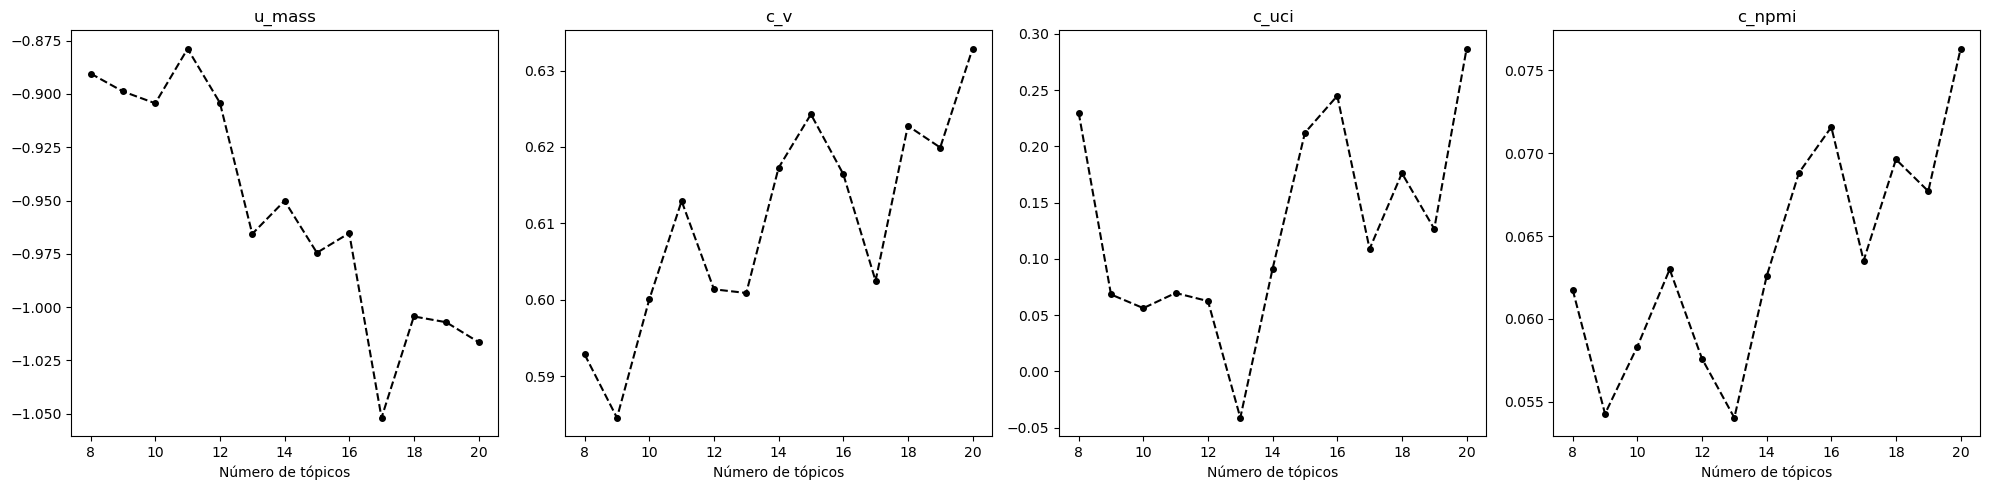

In [13]:
plot_coerencias(coerencias)

### Normalização das coerências 

In [14]:
norm_coerencias = {}
for k, v in coerencias.items():
    x = np.array(v)
    norm_coerencias[k] = (x - min(x)) / (max(x) - min(x))

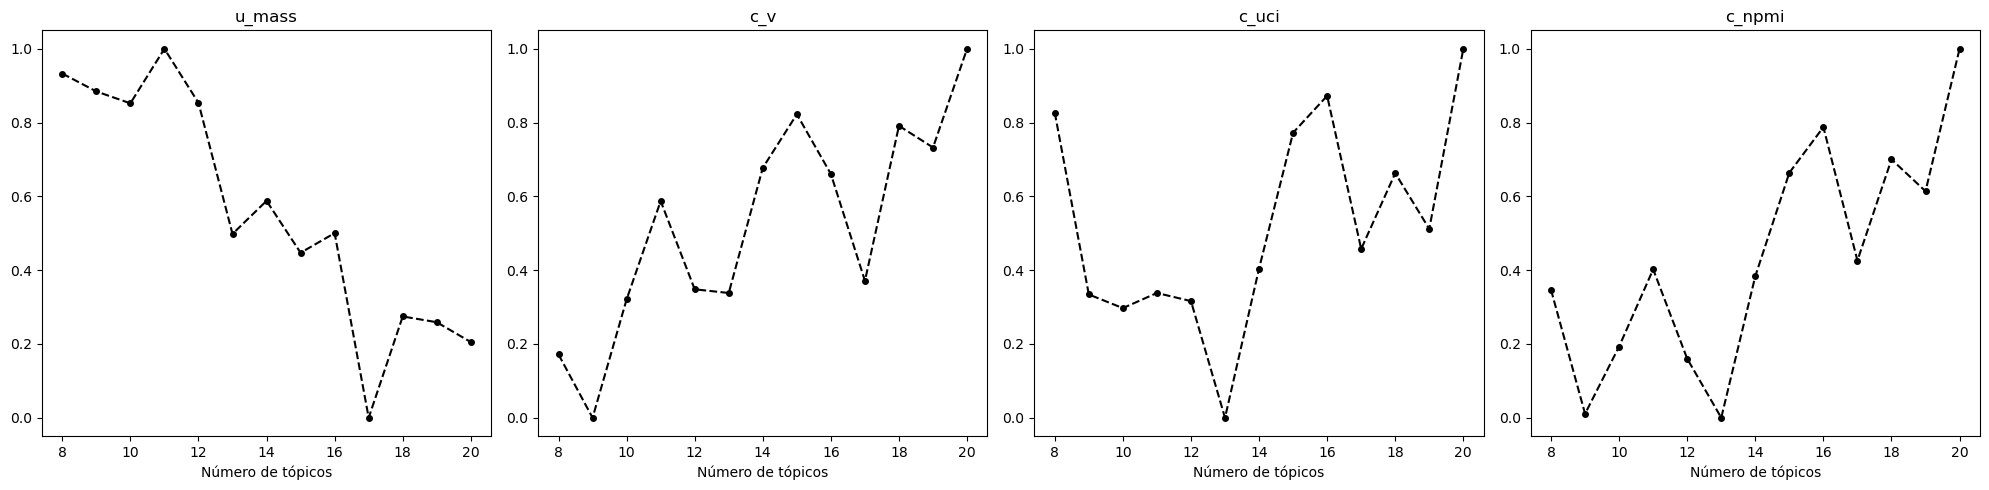

In [15]:
plot_coerencias(norm_coerencias)

In [16]:
medias = sum(norm_coerencias.values()) / len(norm_coerencias)

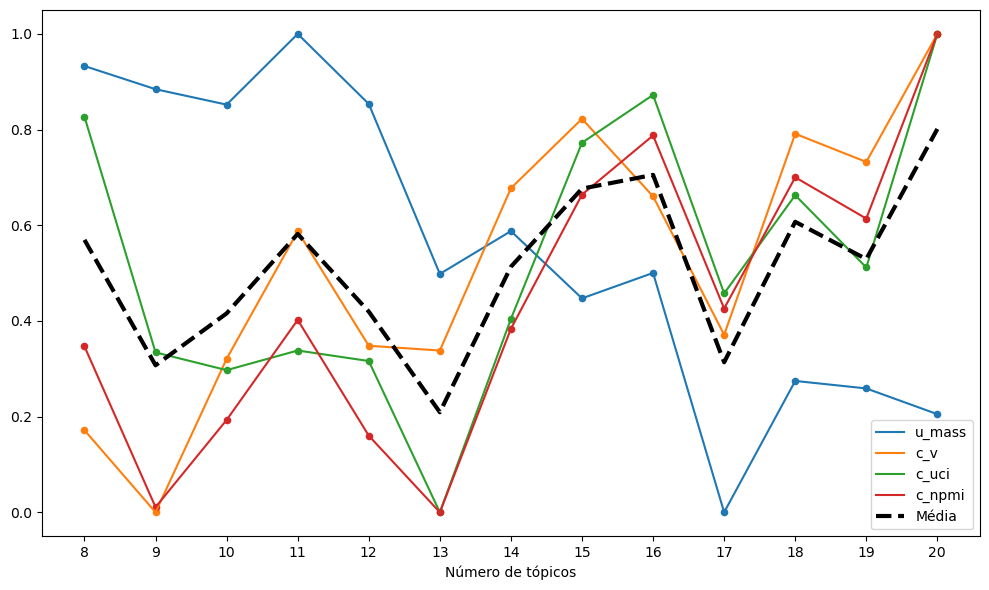

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel('Número de tópicos')

for i, k in enumerate(norm_coerencias):
    y = norm_coerencias[k]
    ax.scatter(n_topicos, y, s=20)
    ax.plot(n_topicos, y, label=k)

ax.plot(n_topicos, medias, label='Média', c='k', lw=3, ls='--')

ax.set_xticks(n_topicos)
ax.legend()
fig.tight_layout()
plt.show()

In [18]:
for i in medias.argsort()[::-1]:
    print(f'{str(n_topicos[i]).rjust(2, "0")} tópicos | {medias[i]:.2f}')

20 tópicos | 0.80
16 tópicos | 0.71
15 tópicos | 0.68
18 tópicos | 0.61
11 tópicos | 0.58
08 tópicos | 0.57
19 tópicos | 0.53
14 tópicos | 0.51
12 tópicos | 0.42
10 tópicos | 0.42
17 tópicos | 0.31
09 tópicos | 0.31
13 tópicos | 0.21


### Número de tópicos = 16

In [10]:
model = lda.run(16)

In [11]:
model.print_topics(num_words=15)

[(0,
  '0.012*"frequência" + 0.010*"onda" + 0.007*"tensão" + 0.007*"elétrico" + 0.007*"tubo" + 0.007*"magnético" + 0.007*"corda" + 0.006*"material" + 0.005*"som" + 0.005*"fio" + 0.005*"bobina" + 0.005*"comprimento" + 0.005*"velocidade" + 0.004*"sinal" + 0.004*"produzir"'),
 (1,
  '0.019*"aluno" + 0.015*"ensino" + 0.012*"estudante" + 0.011*"professor" + 0.008*"aula" + 0.008*"conhecimento" + 0.007*"atividade" + 0.007*"ciência" + 0.006*"curso" + 0.006*"aprendizagem" + 0.006*"conteúdo" + 0.005*"científico" + 0.005*"disciplina" + 0.005*"pesquisa" + 0.005*"didático"'),
 (2,
  '0.025*"partícula" + 0.017*"quântico" + 0.011*"átomo" + 0.010*"interação" + 0.008*"potencial" + 0.008*"elétron" + 0.008*"onda" + 0.007*"fóton" + 0.007*"radiação" + 0.006*"campo" + 0.006*"massa" + 0.005*"elétrons" + 0.005*"atômico" + 0.004*"carga" + 0.004*"spin"'),
 (3,
  '0.009*"ciência" + 0.007*"einstein" + 0.007*"princípio" + 0.006*"livro" + 0.006*"lei" + 0.006*"natureza" + 0.006*"idéia" + 0.006*"matemático" + 0.005*"

In [12]:
df['topico'] = [max(model.get_document_topics(corpu), key=lambda x: x[1])[0] for corpu in corpus]

In [14]:
pd.crosstab(df['seção'], df['topico'])

topico,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
seção,,,,,,,,,,,,,,,,
SEM CATEGORIA,2,2,2,1,1,0,1,0,3,0,0,0,2,1,0,1
ano internacional da luz,0,0,2,0,0,0,0,0,0,0,4,0,0,0,0,0
artigos de einstein e ensaios sobre sua obra,0,0,1,7,0,0,0,1,1,1,0,0,2,0,0,0
artigos de revisão sobre relatividade geral e cosmologia,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0
artigos gerais,64,25,92,18,56,57,1,20,93,90,9,39,108,25,56,53
carta ao editor,0,5,0,0,0,0,2,0,0,0,0,0,0,0,0,0
carta do editor,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0
cartas ao editor,0,11,1,2,0,1,2,1,6,2,0,0,0,1,1,0
desenvolvimento em ensino de física,15,24,1,0,20,0,0,1,0,10,0,3,0,1,3,0


In [15]:
topicos_dict = df.groupby('ano')['topico'].value_counts().unstack().to_dict()

In [54]:
topicos_ = {}
for topico in topicos_dict:
    for ano, valor in topicos_dict[topico].items():
        valor = 0 if np.isnan(valor) else int(valor)
        try:
            topicos_[ano].append(valor)
        except KeyError:
            topicos_[ano] = [valor]

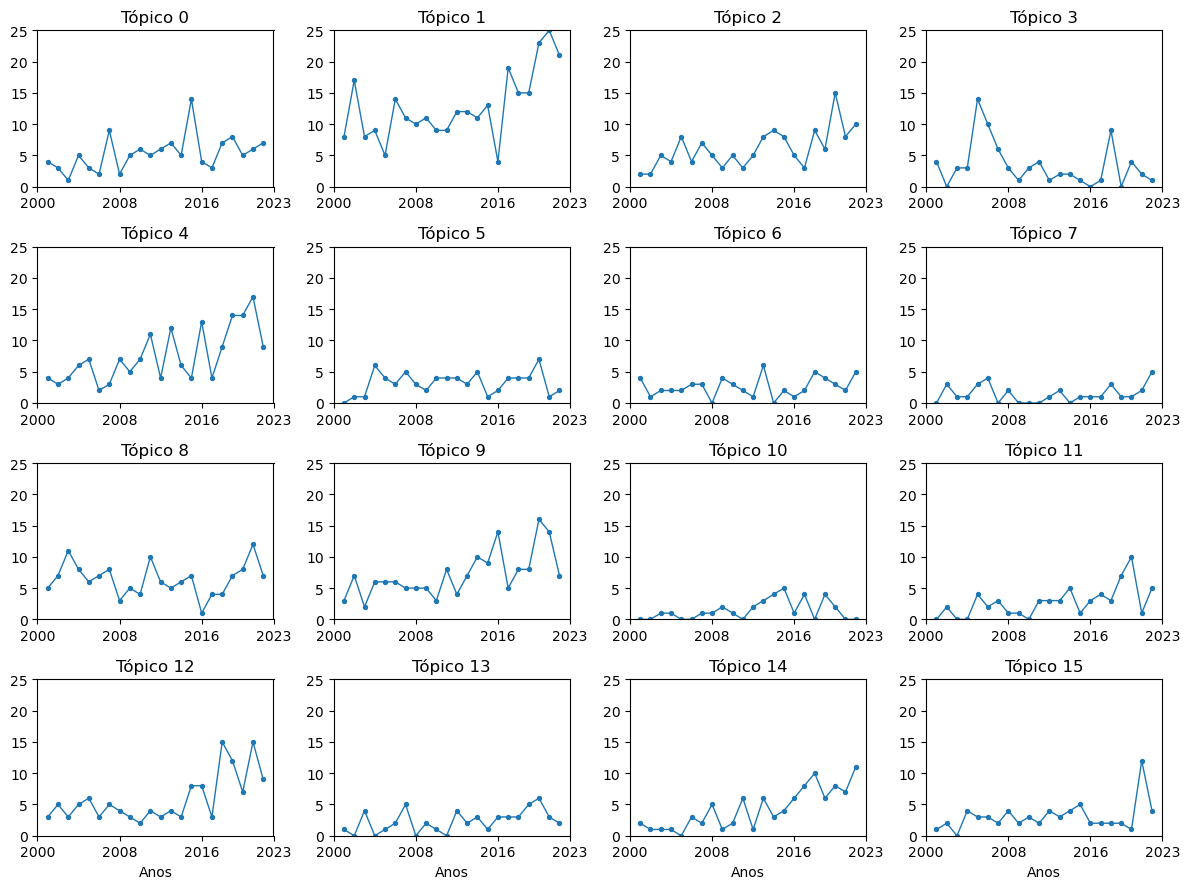

In [103]:
fig, ax = plt.subplots(nrows=4, ncols=4,
                           figsize=(12, 9))
for topico in topicos_dict:
    i, j = topico//4, topico%4
    ax[i, j].set_title(f'Tópico {topico}')
    if i == 3:
        ax[i, j].set_xlabel('Anos')
    
    dados = topicos_dict[topico]
    anos, frequencia = dados.keys(), dados.values()
    freq = np.array(list(frequencia))
    freq[np.isnan(freq)] = 0
    ax[i, j].scatter(anos, freq, s=8)
    ax[i, j].plot(anos, freq, lw=1)
    ax[i, j].set_xlim(2000, 2023)
    ax[i, j].set_xticks([2000, 2008, 2016, 2023])
    ax[i, j].set_ylim(0, 25)
    
fig.tight_layout()
plt.show()    

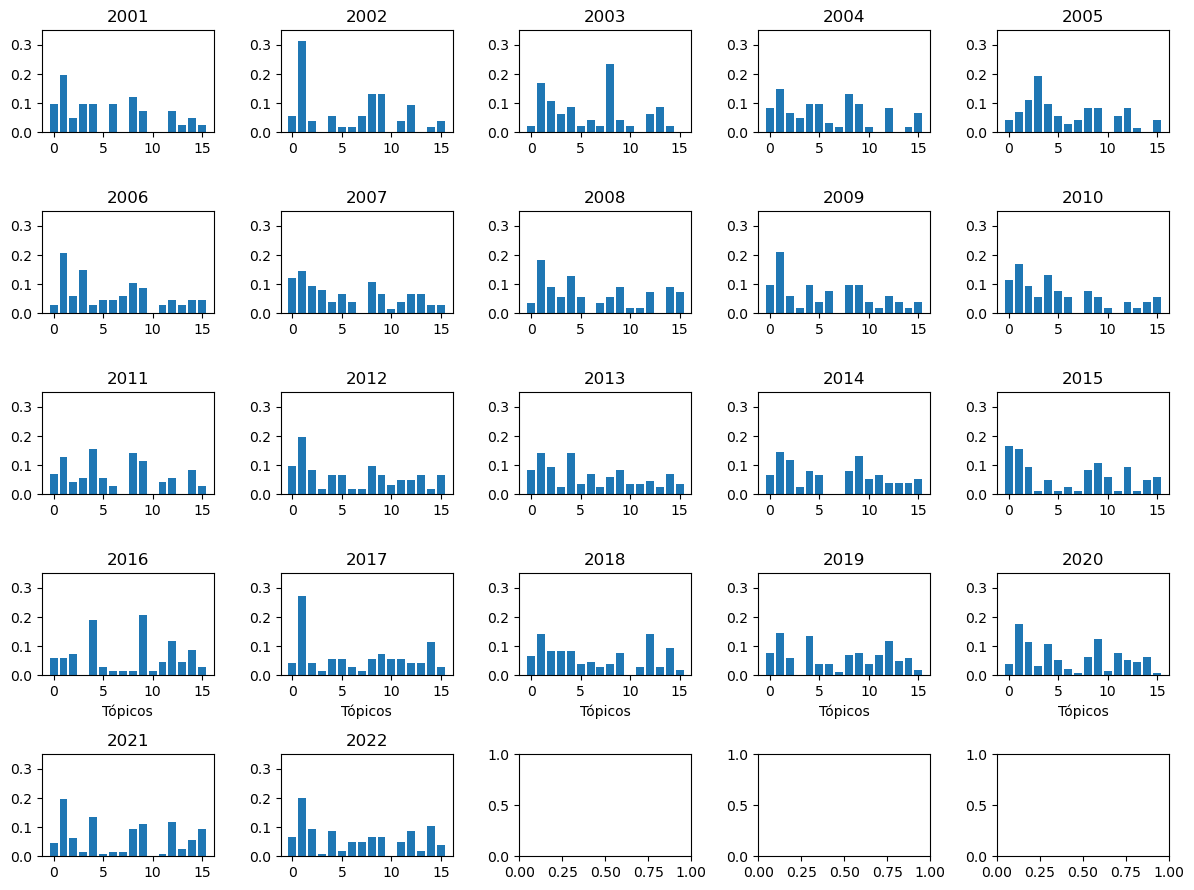

In [88]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                           figsize=(12, 9))
anos_sort = sorted(list(topicos_.keys()))
for ano in anos_sort:
    topicos = topicos_[ano]
    i, j = abs(ano - 2001)// 5, abs(ano - 2001)%5
    ax[i, j].set_title(f'{ano}')
    if i == 3:
        ax[i, j].set_xlabel('Tópicos')
    
    ax[i, j].bar(range(len(topicos)), np.array(topicos)/sum(topicos))
    ax[i, j].set_ylim(0, 0.35)
    ax[i, j].set_yticks([0,0.1, 0.2,0.3])
    
fig.tight_layout()
plt.show()    